In [1]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.2-py3-none-any.whl size=10650 sha256=0936d32fba6a343e39e9c83a979c30dea6e1e2c8d70970562d9f95e17ef961d9
  Stored in directory: /root/.cache/pip/wheels/b4/f6/8a/9daf8831901c3e3805775633404248f10663d1c80b7e5a1314
Successfully built minisom


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.neighbors import KNeighborsClassifier
import pickle
# Evaluate performance
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score



##urls

In [3]:
# Define the function for normalization using tanh-estimator method, excluding specified columns
def normalize_with_tanh_estimator(data, mean_std_dict, exclude_cols):
    normalized_data = pd.DataFrame()
    for col in data.columns:
        if col not in exclude_cols:
            mu, sigma = mean_std_dict[col]
            normalized_col = 0.5 * (np.tanh(0.1 * ((data[col] - mu) / sigma)) + 1)
            normalized_data[col] = normalized_col
        else:
            normalized_data[col] = data[col]  # Keep excluded columns as they are
    return normalized_data

In [4]:
# Function to calculate distance between input sample V and reference point G
def calculate_distance(v, g):
    return np.linalg.norm(v - g)

In [5]:
# Function to classify input sample as attack or normal and update y_pred array
def classify_and_update(sample, d_threshold, sigma, y_pred, g):
  for sam in sample:
    distance_to_g = calculate_distance(sam, g)
    # print("distance_to_g", distance_to_g)
    p_d_greater_than_x = 1 - np.exp(- (distance_to_g / sigma)**2)  # Cumulative distribution function
    is_attack = distance_to_g > d_threshold or p_d_greater_than_x > 0.6  # You can adjust the threshold as needed
    y_pred.append(1 if is_attack else 0)

  return y_pred


In [30]:
def find_best_values(input_sample, g, testlabels):
  sigma_min = 0.001
  sigma_max = 0.5
  # sigma_step = 0.001
  sigma_step = 0.1
  d_threshold_min = 0.001
  d_threshold_max = 0.5
  # d_threshold_step = 0.001
  d_threshold_step = 0.1
  # Generate arrays of varying values for sigma and d_threshold
  sigma_values = np.arange(sigma_min, sigma_max + sigma_step, sigma_step)
  d_threshold_values = np.arange(d_threshold_min, d_threshold_max + d_threshold_step, d_threshold_step)

  # Initialize an empty dataframe
  df_results = pd.DataFrame(columns=['sigma', 'd_threshold', 'accuracy', 'FDR'])
  max = len(sigma_values)*len(d_threshold_values)
  i=1
  # Initialize an empty list to store results
  results_list = []

  # Example usage loop to calculate accuracy and FDR for each parameter combination
  for sigma in sigma_values:
      for d_threshold in d_threshold_values:
          y_pred = []  # Initialize y_pred for each combination of parameters
          y_pred = classify_and_update(input_sample, d_threshold, sigma, y_pred, g)
          ypred = np.array(y_pred)

          # Evaluate performance
          report = classification_report(testlabels, y_pred, zero_division=1, output_dict=True)
          accuracy = report['accuracy']

          # Calculate False Detection Rate (FDR)
          precision_recall = report['1']  # Assuming '1' represents DDoS class
          FDR = (1 - precision_recall['precision']) * 100

          # Append the results to the list
          results_list.append({'sigma': sigma, 'd_threshold': d_threshold, 'accuracy': accuracy, 'FDR': FDR})
          # print(f"\r{i/max * 100}--- {i} OF {max} accuracy at {accuracy} FDR AT {FDR}")
          i=i+1


  # Assuming df_results contains the data from the previous code snippets
  print(results_list)
  # Convert the list of dictionaries to a DataFrame
  # Create the DataFrame after the loop
  df_results = pd.DataFrame(results_list)
  # Find the row with maximum accuracy
  max_accuracy_row = df_results[df_results['accuracy'] == df_results['accuracy'].max()]
  min_fdr_row = df_results[df_results['FDR'] == df_results['FDR'].min()]
  # Extract the corresponding sigma and d_threshold values
  max_accuracy_sigma = max_accuracy_row['sigma'].values[0]
  max_accuracy_d_threshold = max_accuracy_row['d_threshold'].values[0]
  max_accuracy_accuracy = max_accuracy_row['accuracy'].values[0]
  max_accuracy_fdr = max_accuracy_row['FDR'].values[0]

  min_fdr_sigma = min_fdr_row['sigma'].values[0]
  min_fdr_d_threshold = min_fdr_row['d_threshold'].values[0]
  min_fdr_accuracy = min_fdr_row['accuracy'].values[0]
  min_fdr_fdr = min_fdr_row['FDR'].values[0]

  # Create the DataFrame after the loop
  return {'max_accuracy_sigma': max_accuracy_sigma, 'max_accuracy_d_threshold': max_accuracy_d_threshold, 'max_accuracy_accuracy': max_accuracy_accuracy, 'max_accuracy_fdr': max_accuracy_fdr, 'min_fdr_sigma': min_fdr_sigma, 'min_fdr_d_threshold': min_fdr_d_threshold,'min_fdr_accuracy': min_fdr_accuracy, 'min_fdr_fdr': min_fdr_fdr}


In [31]:
def main(df, com, bandflag):

  if bandflag == 1:
    # Check if the column exists
    column_to_drop = 'bandwidth'
    if column_to_drop in df.columns:
        # Drop the column
        df.drop(columns=[column_to_drop], inplace=True)
        print(f"\n'{column_to_drop}' column dropped.")


  # Define the columns to exclude from normalization
  exclude_cols = ['label']  # Add more columns here if needed
  # Calculate and store the mean and standard deviation for each dimension, excluding specified columns
  mean_std_dict = {}
  for col in df.columns:
      if col not in exclude_cols:
          mean_std_dict[col] = (df[col].mean(), df[col].std())

  # Normalize the dataset using tanh-estimator method, excluding specified columns
  normalized_df = normalize_with_tanh_estimator(df, mean_std_dict, exclude_cols)


  # Filter rows where label equals 0
  filtered_df = normalized_df[normalized_df['label'] == 0]

  # Concatenate the filtered rows into a new DataFrame
  result_df = pd.concat([filtered_df[col] for col in filtered_df.columns], axis=1)

  # Reset index if needed
  result_df.reset_index(drop=True, inplace=True)

  traindf = (result_df)

  X = normalized_df.iloc[:, :-1].values
  y = normalized_df.iloc[:, -1].values

  trainX = traindf.iloc[:, :-1].values
  trainy = traindf.iloc[:, -1].values

  # Splitting dataset into training and testing
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  # Initialize and train SOM
  som_size = 30  # Example size, adjust based on your dataset

  som = MiniSom(som_size, som_size, X_train.shape[1], sigma=15, learning_rate=0.1, random_seed=0 )

  som.random_weights_init(trainX)

  u_matrixfirst = som.distance_map()  # Get the U-matrix
  # Initialize list to store quantization errors
  quantization_errors = []
  som.train_batch(trainX, 1000, verbose = "true")

  u_matrixlast = som.distance_map()  # Get the U-matrix

  # Plot the U-Matrix before training
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.title("U-Matrix Before Training")
  plt.pcolor(u_matrixfirst, cmap='viridis')
  plt.colorbar()

  # Plot the U-Matrix after training
  plt.subplot(1, 2, 2)
  plt.title("U-Matrix After Training")
  plt.pcolor(u_matrixlast, cmap='viridis')
  plt.colorbar()

  plt.tight_layout()
  plt.show()


  # testvalues = X_test
  # testvalues = X_train
  testvalues = X
  # testlabels = y_train
  testlabels = y


  # Calculate the reference point G
  g = np.median(som.get_weights(), axis=(0, 1))


  # Example usage
  input_sample = testvalues  # Example input sample (you can replace this with your actual data)
  d_threshold = 0.13309999999999966  # Predefined distance threshold

  sigma =  0.139099999999999  # Probability threshold

  y_pred = []

  y_pred=classify_and_update(input_sample, d_threshold, sigma, y_pred, g)
  ypred = np.array(y_pred)

  # report = classification_report(testlabels, ypred, zero_division=1)
  # print(report)
  # print("here1")
  # print(len(testlabels))
  # print(len(y_pred))
  accuracy = accuracy_score(testlabels, y_pred)
  # print("Accuracy:", accuracy)
  # print(classification_report(testlabels, y_pred, zero_division=1))
  # print("here2")
  # print("Here")
  precision_recall = classification_report(testlabels, y_pred, output_dict=True, zero_division=1)
  precision_ddos = precision_recall['1']  # Assuming '1' represents DDoS class

  FDR = (1 - precision_ddos['precision'])* 100
  print(f"False Detection Rate (FDR): {FDR:.2f}%")

  #ROC Curve

  fpr, tpr, thresholds = roc_curve(testlabels, y_pred)
  roc_auc = auc(fpr, tpr)
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc='lower right')
  plt.show()

  best_values = find_best_values(input_sample, g, testlabels)

  # print(best_values

  return com, accuracy, FDR, roc_auc, precision_ddos['precision'], sigma, d_threshold, g, mean_std_dict, best_values


'bandwidth' column dropped.
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.004229829085333364


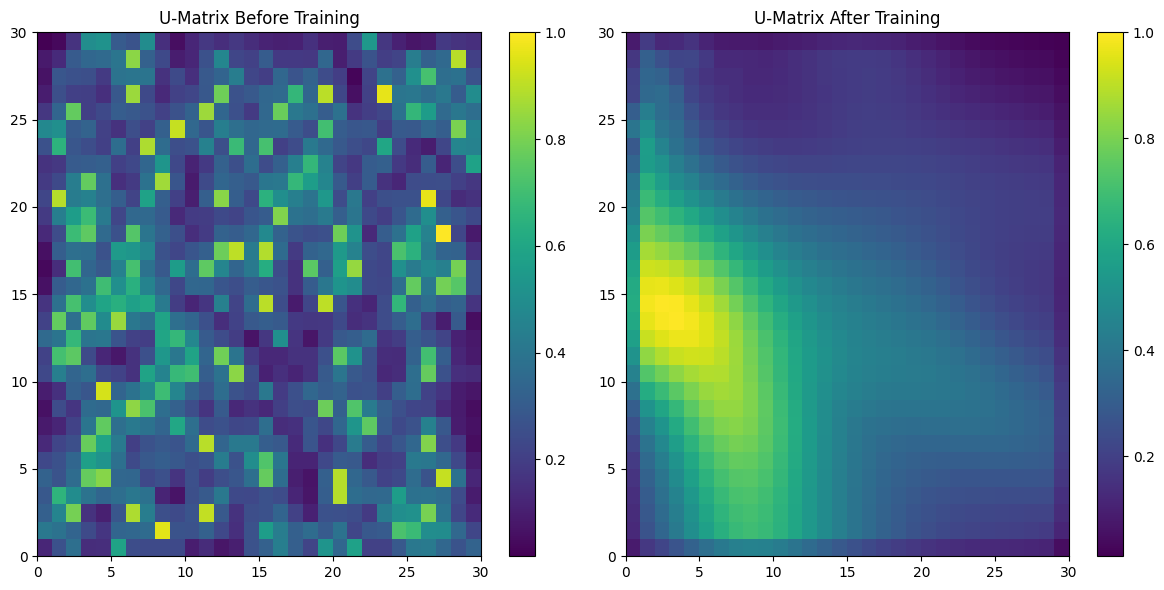

False Detection Rate (FDR): 6.01%


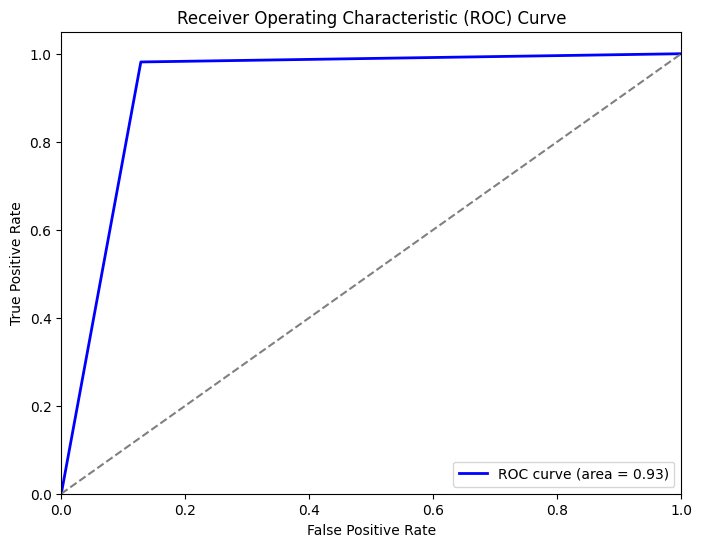

[{'sigma': 0.001, 'd_threshold': 0.001, 'accuracy': 0.6717724288840262, 'FDR': 32.822757111597376}, {'sigma': 0.001, 'd_threshold': 0.101, 'accuracy': 0.6717724288840262, 'FDR': 32.822757111597376}, {'sigma': 0.001, 'd_threshold': 0.201, 'accuracy': 0.6717724288840262, 'FDR': 32.822757111597376}, {'sigma': 0.001, 'd_threshold': 0.30100000000000005, 'accuracy': 0.6717724288840262, 'FDR': 32.822757111597376}, {'sigma': 0.001, 'd_threshold': 0.401, 'accuracy': 0.6717724288840262, 'FDR': 32.822757111597376}, {'sigma': 0.001, 'd_threshold': 0.501, 'accuracy': 0.6717724288840262, 'FDR': 32.822757111597376}, {'sigma': 0.101, 'd_threshold': 0.001, 'accuracy': 0.6717724288840262, 'FDR': 32.822757111597376}, {'sigma': 0.101, 'd_threshold': 0.101, 'accuracy': 0.9409190371991247, 'FDR': 7.18654434250765}, {'sigma': 0.101, 'd_threshold': 0.201, 'accuracy': 0.9409190371991247, 'FDR': 7.18654434250765}, {'sigma': 0.101, 'd_threshold': 0.30100000000000005, 'accuracy': 0.9409190371991247, 'FDR': 7.1865

In [32]:
# Load the dataset

urls = []
comments = []

# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/combined%20Dataset.csv")
# comments.append("1s split")
# #self made data
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/som_data.csv")
# comments.append("self made data")
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/1ssplit%20combined%20dataset%20CAIDA%202007.csv")
# comments.append("1s split with ")

#new 2s splits
# #filled
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/caida2007/csv/2ssplit%20combined%20dataset%20CAIDA%202007%20filled.csv")
# comments.append("filled 2s split with band")
# #unfilled
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/caida2007/csv/2ssplit%20combined%20dataset%20CAIDA%202007%20unfilled.csv")
# comments.append("unfilled 2s split with band")

# #filled
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/caida2007/csv/2ssplit%20combined%20dataset%20CAIDA%202007%20filled.csv")
# comments.append("filled 2s split without band")
#unfilled
urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/caida2007/csv/2ssplit%20combined%20dataset%20CAIDA%202007%20unfilled.csv")
comments.append("unfilled 2s split without band")




resultant_columns = ['comments', 'accuracy', 'FDR', 'roc_auc', 'precision', 'sigma', 'd_threshold', 'g', 'mean_std_dict', 'best_values']
# resultant_df = pd.DataFrame(columns=resultant)
resultant=[]
iteration = 0
for url in urls:
  com = comments[iteration]
  if 'without band' in com:
    bandflag = 1
  else:
    bandflag = 0

  df = pd.read_csv(url)
  resultant.append(main(df,com, bandflag))
  iteration += 1

In [33]:
resultant_df = pd.DataFrame(resultant, columns=resultant_columns)

In [34]:
print(resultant)

[('unfilled 2s split without band', 0.9452954048140044, 6.006240249609984, 0.9264685124864278, 0.9399375975039002, 0.139099999999999, 0.13309999999999966, array([0.43150412, 0.43881149, 0.43337141, 0.47333433, 0.43714744]), {'etpSrcIP': (8.756124716939265, 4.466603853932388), 'etpSrcP': (14.831868935904387, 4.516540979873303), 'etpDstP': (14.637699935719569, 4.038227662511185), 'etpProtocol': (0.35033490480097373, 0.2064099100881174), 'totalPacket': (196688.50929978117, 155065.65289005972)}, {'max_accuracy_sigma': 0.201, 'max_accuracy_d_threshold': 0.101, 'max_accuracy_accuracy': 0.9420131291028446, 'max_accuracy_fdr': 7.044410413476266, 'min_fdr_sigma': 0.201, 'min_fdr_d_threshold': 0.201, 'min_fdr_accuracy': 0.8966083150984683, 'min_fdr_fdr': 0.0})]


In [35]:
resultant_df


,comments,accuracy,FDR,roc_auc,precision,sigma,d_threshold,g,mean_std_dict,best_values
0,unfilled 2s split without band,0.945295,6.00624,0.926469,0.939938,0.1391,0.1331,"[0.43150411637581143, 0.43881149461722546, 0.4...","{'etpSrcIP': (8.756124716939265, 4.46660385393...","{'max_accuracy_sigma': 0.201, 'max_accuracy_d_..."


In [36]:
for resultant_d in resultant_df['g']:
  print(resultant_d)

[0.43150412 0.43881149 0.43337141 0.47333433 0.43714744]


In [37]:
resultant_df.to_csv('resultant_df.csv')

In [38]:
resultant_df.to_parquet('resultant_df.parquet')